releated work
for single and double precision only. but good for calculate ops/bytes ratio
https://github.com/ekondis/mixbench


Matrix-multiplication and N*N
notebook example,
https://github.com/mikecroucher/Jupyter-Matrix-Matrix?tab=readme-ov-file


# ops/bytes
https://docs.nvidia.com/deeplearning/performance/dl-performance-gpu-background/index.html#understand-perf

the arithmetic intensity is a first-order approximation;

The arithmetic intensity and ops:byte ratio analysis assumes that a workload is sufficiently large to saturate a given processor’s math and memory pipelines. However, if the workload is not large enough, or does not have sufficient parallelism, the processor will be under-utilized and performance will be limited by latency. For example, consider the launch of a single thread that will access 16 bytes and perform 16000 math operations. While the arithmetic intensity is 1000 FLOPS/B and the execution should be math-limited on a V100 GPU, creating only a single thread grossly under-utilizes the GPU, leaving nearly all of its math pipelines and execution resources idle. Furthermore, the arithmetic intensity calculation assumes that inputs and outputs are accessed from memory exactly once. It is not unusual for algorithm implementations to read input elements multiple times, which would effectively reduce arithmetic intensity. Thus, the arithmetic intensity is a first-order approximation; profiler information should be used if more accurate analysis is needed.

exmaple by v100

V100 has a peak math rate of 125 FP16 Tensor TFLOPS, an off-chip memory bandwidth of approx. 900 GB/s, and an on-chip L2 bandwidth of 3.1 TB/s, giving it a ops:byte ratio between 40 and 139, depending on the source of an operation’s data (on-chip or off-chip memory).

example for t4 will be
mixed-precision 65 tflops with bandwidth 300gb/s

In [1]:
# v100
print(125/0.9)
print(125/3.1)

138.88888888888889
40.32258064516129


In [3]:
print(2.6/0.2)

13.0


In [2]:
# t4
print(65/0.3)

216.66666666666669


question to think
A100 is X of V100. B series is X of H100. Do we really get X performance in AI.

GEMM is a foundmental part. I am not going to answer the question.
In ideal scenario, what is the full power free gpu t4, P100. 

Further question, give this, how in4/in8 will change the math bound vs memory bound.
predict, is project digits a good machine for personal researcher?

About math or memory limited.
https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html

https://developer.nvidia.com/blog/cutlass-linear-algebra-cuda/

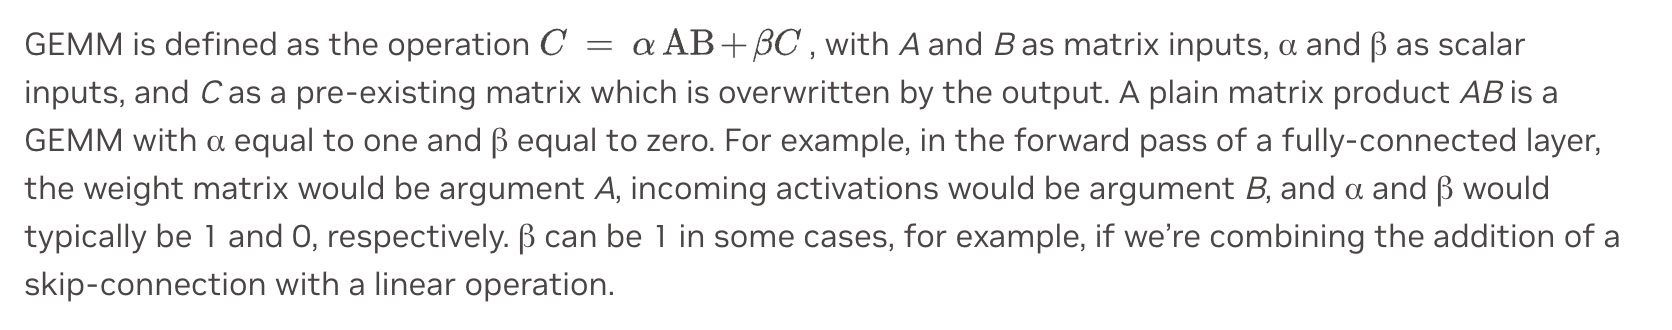

In [3]:
1016/16

63.5

In [4]:
import torch
from benchmark import benchmark_GEMM

In [5]:
torch.mps.empty_cache() # May have minor impact


In [6]:
# Enable TF32 (Tensor Float 32) on Ampere GPUs
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [7]:
torch.backends.mps.is_available()

True

In [8]:
2 * 1e12

2000000000000.0

In [31]:
print(f"MPS built: {torch.backends.mps.is_built()}")
multiplier = 8
result = []
for n in [1, 16, 32, 64, 128, 256, 512, 1024]:
    result.append(benchmark_GEMM(matrix_shape= (1024*multiplier, n*multiplier, 1024*multiplier), dtype = torch.float16, device = 'mps', number = 20))

MPS built: True
dtype is torch.float16, bytes_per_element: 2
mps:0
mps:0
tflops: 0.09789212682328345, x: 0.010968622899963521, arithmetic_intensity: 7.984405458089668
dtype is torch.float16, bytes_per_element: 2
mps:0
mps:0
tflops: 1.0690636948647885, x: 0.016070014599245043, arithmetic_intensity: 124.12121212121212
dtype is torch.float16, bytes_per_element: 2
mps:0
mps:0
tflops: 1.4484155169616304, x: 0.023722293751779942, arithmetic_intensity: 240.94117647058823
dtype is torch.float16, bytes_per_element: 2
mps:0
mps:0
tflops: 1.7569211138205119, x: 0.039113581250421706, arithmetic_intensity: 455.1111111111111
dtype is torch.float16, bytes_per_element: 2
mps:0
mps:0
tflops: 1.9148211593277475, x: 0.07177639165020082, arithmetic_intensity: 819.2
dtype is torch.float16, bytes_per_element: 2
mps:0
mps:0
tflops: 2.0744340923792004, x: 0.13250741874799132, arithmetic_intensity: 1365.3333333333333
dtype is torch.float16, bytes_per_element: 2
mps:0
mps:0
tflops: 2.189870509130976, x: 0.25104

In [32]:
import pandas as pd
df = pd.DataFrame(result, columns=['tflops', 'time', 'arithmetic_intensity'])

In [33]:
df['median_time'] = df['time'].apply(lambda x:  x.median)

M1 reach its full power when Arithmetic Intensity is very high.
- task to do, find the related tflops and memeory bindswith for m1 chip.
- test it on other gpu to see the result.
- add a point to the plot for theortical ops/bytes.

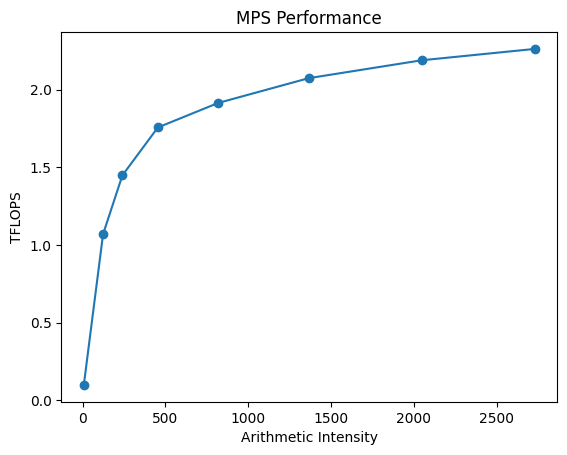

In [34]:
# plot the results, tflops against arithmetic intensity
import matplotlib.pyplot as plt
plt.plot(df['arithmetic_intensity'], df['tflops'], 'o-')
plt.xlabel('Arithmetic Intensity')
plt.ylabel('TFLOPS')
plt.title('MPS Performance')
plt.show()

In [30]:
df

,tflops,time,arithmetic_intensity,median_time
0,0.215236,<torch.utils.benchmark.utils.common.Measuremen...,15.968811,0.039909
1,1.454079,<torch.utils.benchmark.utils.common.Measuremen...,248.242424,0.094520
2,1.784990,<torch.utils.benchmark.utils.common.Measuremen...,481.882353,0.153994
3,2.006748,<torch.utils.benchmark.utils.common.Measuremen...,910.222222,0.273954
4,2.133988,<torch.utils.benchmark.utils.common.Measuremen...,1638.400000,0.515238
5,2.200189,<torch.utils.benchmark.utils.common.Measuremen...,2730.666667,0.999470
6,2.219208,<torch.utils.benchmark.utils.common.Measuremen...,4096.000000,1.981809


In [11]:
print(f"MPS built: {torch.backends.mps.is_built()}")
multiplier = 16
benchmark_GEMM(matrix_shape= (1024*multiplier, 1024*multiplier, 1024*multiplier), dtype = torch.float16, device = 'mps', number = 2)

MPS built: True
dtype is torch.float16, bytes_per_element: 2
mps:0
mps:0
tflops: 2.189643575166504, x: 4.0171346249990165, arithmetic_intensity: 5461.333333333333


(2.189643575166504,
 a @ b + c; torch.mps.synchronize()
   4.02 s
   1 measurement, 2 runs , 1 thread,
 5461.333333333333)

In [24]:
print(f"MPS built: {torch.backends.mps.is_built()}")
multiplier = 16
benchmark_GEMM(matrix_shape= (1024*multiplier, 1024*multiplier, 1024*multiplier), dtype = torch.float32, device = 'mps', number = 2)

MPS built: True
dtype is torch.float32, bytes_per_element: 4
mps:0
mps:0


(1.4387500119217027,
 a @ b + c; torch.mps.synchronize()
   6.11 s
   1 measurement, 2 runs , 1 thread,
 2730.6666666666665)

memory limited: arithmetic intensity lower than chip flops:B

math limited: arithmetic intensity higher than FLOPS:B

if set n =1, will be memory limited

In [12]:
print(f"MPS built: {torch.backends.mps.is_built()}")
scale = 32
benchmark_GEMM(matrix_shape= (1024*scale, 1, 1024*scale), dtype = torch.float16, device = 'mps', number = 2)

MPS built: True
mps:0
mps:0


(0.0064314804494468355,
 a @ b + c; torch.mps.synchronize()
   333.90 ms
   1 measurement, 2 runs , 1 thread,
 0.9999389685688129)

in theory 2.6 tflops
https://www.apple.com/gr/newsroom/2020/11/apple-unleashes-m1/

In [ ]:
print(f"MPS built: {torch.backends.mps.is_built()}")
multiplier = 24
benchmark_GEMM(matrix_shape= (1024*multiplier, 1024*multiplier, 1024*multiplier), dtype = torch.float16, device = 'cuda', number = 25)